In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob #to walk through folder structure
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,f1_score

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#2 -> Filter out INFO & WARNING messages 
# tf.autograph.set_verbosity(1)

In [2]:
def generate_data(batch_size,img_height,img_width,train_dir,val_dir):

    batch_size = batch_size #32
    img_height = img_height #128
    img_width = img_width #128


    #train_dir = 'data/skinlesion_500_split/train'
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      labels='inferred',
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    #val_dir = 'data/skinlesion_500_split/val'
    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      labels='inferred',
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    

    return train_ds,val_ds

In [3]:
train_dir = 'data/skinlesion_500_split/train'
val_dir = 'data/skinlesion_500_split/val'
train_ds,val_ds = generate_data(16,128,128,train_dir,val_dir)

Found 2450 files belonging to 7 classes.
Found 700 files belonging to 7 classes.


In [7]:
img_height = 128
img_width = 128
batch_size=16
test_dir = 'data/skinlesion_500_split/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
          test_dir,
          labels='inferred',
          seed=123,
          image_size=(img_height, img_width),
          batch_size=batch_size)

Found 350 files belonging to 7 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

In [3]:
##configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(50).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1), #tested with 0.3 -too much fluctuation in val performance
    layers.RandomZoom(0.1),
  ]
)

In [4]:
#model build
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

In [8]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 22:42:09.041315: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 22:42:09.043367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - ETA: 0s - loss: 1.8737 - accuracy: 0.2788

2022-12-10 22:42:34.192580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 27s 312ms/step - loss: 1.8737 - accuracy: 0.2788 - val_loss: 1.9051 - val_accuracy: 0.1843
Epoch 2/50
77/77 [==============================] - 22s 288ms/step - loss: 1.5365 - accuracy: 0.4024 - val_loss: 1.9371 - val_accuracy: 0.1586
Epoch 3/50
77/77 [==============================] - 22s 287ms/step - loss: 1.4660 - accuracy: 0.4245 - val_loss: 1.7913 - val_accuracy: 0.3386
Epoch 4/50
77/77 [==============================] - 22s 287ms/step - loss: 1.3706 - accuracy: 0.4665 - val_loss: 1.7515 - val_accuracy: 0.2657
Epoch 5/50
77/77 [==============================] - 22s 287ms/step - loss: 1.2392 - accuracy: 0.5229 - val_loss: 1.4814 - val_accuracy: 0.5071
Epoch 6/50
77/77 [==============================] - 22s 288ms/step - loss: 1.2431 - accuracy: 0.5196 - val_loss: 2.2136 - val_accuracy: 0.2600
Epoch 7/50
77/77 [==============================] - 22s 287ms/step - loss: 1.1589 - accuracy: 0.5539 - val_loss: 1.6601 - val_accuracy: 0.3386
Epoch 8/50

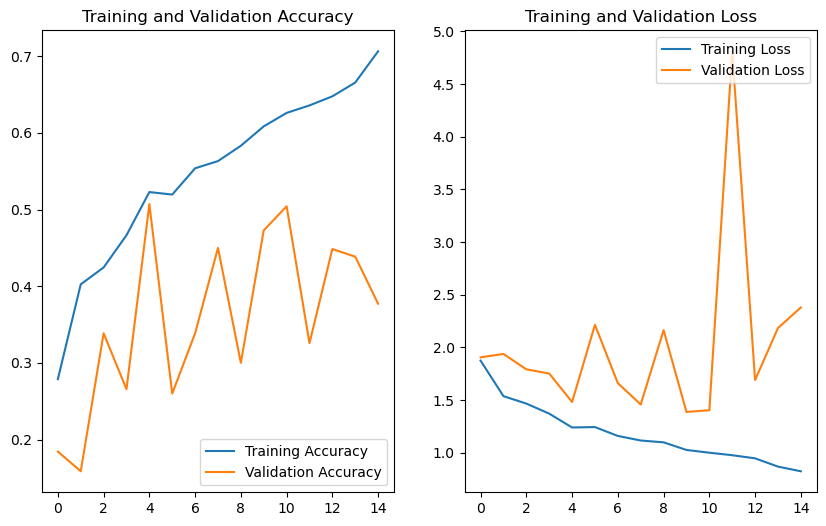

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
extend_epochs =25
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

Epoch 15/39
77/77 [==============================] - 22s 288ms/step - loss: 0.8278 - accuracy: 0.7012 - val_loss: 1.4961 - val_accuracy: 0.5143
Epoch 16/39
77/77 [==============================] - 22s 290ms/step - loss: 0.7637 - accuracy: 0.7167 - val_loss: 1.4001 - val_accuracy: 0.5614
Epoch 17/39
77/77 [==============================] - 22s 291ms/step - loss: 0.7507 - accuracy: 0.7310 - val_loss: 1.4512 - val_accuracy: 0.5171
Epoch 18/39
77/77 [==============================] - 22s 290ms/step - loss: 0.7527 - accuracy: 0.7314 - val_loss: 1.5093 - val_accuracy: 0.4886
Epoch 19/39
77/77 [==============================] - 22s 290ms/step - loss: 0.7615 - accuracy: 0.7188 - val_loss: 1.5709 - val_accuracy: 0.5157
Epoch 20/39
77/77 [==============================] - 22s 288ms/step - loss: 0.6826 - accuracy: 0.7449 - val_loss: 1.3626 - val_accuracy: 0.5586
Epoch 21/39
77/77 [==============================] - 22s 290ms/step - loss: 0.6448 - accuracy: 0.7531 - val_loss: 2.2053 - val_accuracy:

### Comments:
Training has improved only slightly even after 25 additional epochs 

In [7]:
## modified model
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
    
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       295040    
                                                      

In [8]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-10 23:07:48.131970: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 23:07:48.134120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - ETA: 0s - loss: 1.9660 - accuracy: 0.1400

2022-12-10 23:08:31.186646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 46s 560ms/step - loss: 1.9660 - accuracy: 0.1400 - val_loss: 1.9396 - val_accuracy: 0.1714
Epoch 2/50
77/77 [==============================] - 42s 543ms/step - loss: 1.8866 - accuracy: 0.1935 - val_loss: 1.7312 - val_accuracy: 0.2771
Epoch 3/50
77/77 [==============================] - 42s 541ms/step - loss: 1.7514 - accuracy: 0.2620 - val_loss: 1.7227 - val_accuracy: 0.2657
Epoch 4/50
77/77 [==============================] - 42s 541ms/step - loss: 1.6795 - accuracy: 0.3004 - val_loss: 1.6840 - val_accuracy: 0.2586
Epoch 5/50
77/77 [==============================] - 42s 543ms/step - loss: 1.6562 - accuracy: 0.3127 - val_loss: 1.6816 - val_accuracy: 0.3143
Epoch 6/50
77/77 [==============================] - 1113s 15s/step - loss: 1.5750 - accuracy: 0.3686 - val_loss: 1.5043 - val_accuracy: 0.4129
Epoch 7/50
77/77 [==============================] - 42s 544ms/step - loss: 1.4819 - accuracy: 0.4024 - val_loss: 1.4825 - val_accuracy: 0.4157
Epoch 8/50

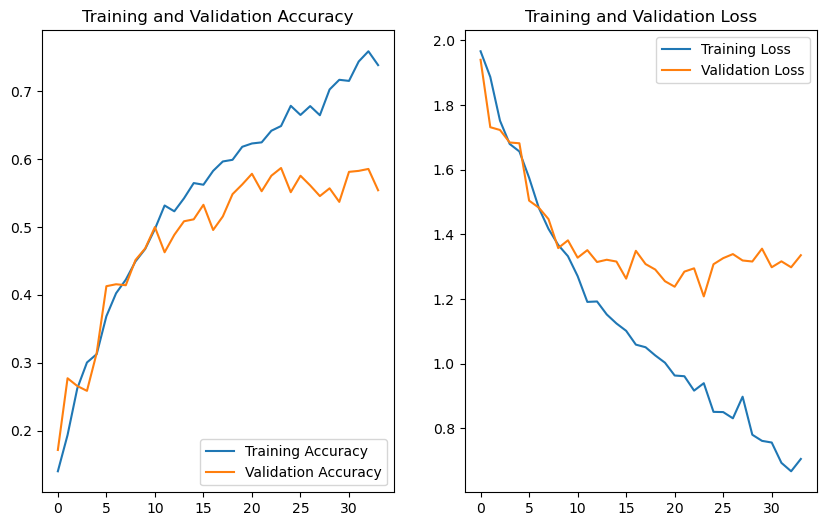

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(34)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
extend_epochs =16
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

In [2]:
batch_size = 16
img_height = 64
img_width = 64

train_dir = 'data/skinlesion_500_split/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dir = 'data/skinlesion_500_split/val'
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_dir = 'data/skinlesion_500_split/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 2450 files belonging to 7 classes.
Metal device set to: Apple M2
Found 700 files belonging to 7 classes.
Found 350 files belonging to 7 classes.
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


2022-12-11 00:14:22.902803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 00:14:22.903148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
## modified model-increasing dropout
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
    
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       295040    
                                                      

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-11 00:15:03.109880: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-11 00:15:03.112892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


154/154 [==============================] - ETA: 0s - loss: 1.9505 - accuracy: 0.1486

2022-12-11 00:15:25.746477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


154/154 [==============================] - 24s 144ms/step - loss: 1.9505 - accuracy: 0.1486 - val_loss: 1.9455 - val_accuracy: 0.1429
Epoch 2/50
154/154 [==============================] - 20s 131ms/step - loss: 1.9472 - accuracy: 0.1449 - val_loss: 1.9455 - val_accuracy: 0.1457
Epoch 3/50
154/154 [==============================] - 20s 132ms/step - loss: 1.9470 - accuracy: 0.1420 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 4/50
154/154 [==============================] - 20s 132ms/step - loss: 1.9464 - accuracy: 0.1416 - val_loss: 1.9443 - val_accuracy: 0.1443
Epoch 5/50
154/154 [==============================] - 20s 132ms/step - loss: 1.9459 - accuracy: 0.1359 - val_loss: 1.9342 - val_accuracy: 0.1429
Epoch 6/50
154/154 [==============================] - 20s 132ms/step - loss: 1.9491 - accuracy: 0.1416 - val_loss: 1.9455 - val_accuracy: 0.1429
Epoch 7/50
154/154 [==============================] - 20s 132ms/step - loss: 1.9266 - accuracy: 0.1776 - val_loss: 1.8374 - val_accuracy: 0.2

### Using dataset with 80-20 split to obtain more sample size for training images

In [8]:
batch_size = 32
img_height = 128
img_width = 128

train_dir = 'data/skinlesion_500_split_8020/train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dir = 'data/skinlesion_500_split_8020/val'
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 2800 files belonging to 7 classes.
Found 700 files belonging to 7 classes.
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1), #tested with 0.3 -too much fluctuation in val performance
#     layers.RandomZoom(0.1),
  ]
)

In [10]:
## modified model-increasing dropout
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
    
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       295040    
                                                      

In [11]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-11 23:00:05.243732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 1.9536 - accuracy: 0.1518

2022-12-11 23:00:44.521802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 42s 464ms/step - loss: 1.9536 - accuracy: 0.1518 - val_loss: 1.9352 - val_accuracy: 0.1971
Epoch 2/50
88/88 [==============================] - 41s 463ms/step - loss: 1.8543 - accuracy: 0.2125 - val_loss: 1.8427 - val_accuracy: 0.2043
Epoch 3/50
88/88 [==============================] - 41s 462ms/step - loss: 1.7765 - accuracy: 0.2657 - val_loss: 1.7316 - val_accuracy: 0.2557
Epoch 4/50
88/88 [==============================] - 1093s 13s/step - loss: 1.7402 - accuracy: 0.2961 - val_loss: 1.6828 - val_accuracy: 0.3257
Epoch 5/50
88/88 [==============================] - 41s 461ms/step - loss: 1.6642 - accuracy: 0.3336 - val_loss: 1.6650 - val_accuracy: 0.3371
Epoch 6/50
88/88 [==============================] - 41s 464ms/step - loss: 1.5428 - accuracy: 0.4011 - val_loss: 1.4290 - val_accuracy: 0.4471
Epoch 7/50
88/88 [==============================] - 41s 463ms/step - loss: 1.4348 - accuracy: 0.4325 - val_loss: 1.3784 - val_accuracy: 0.4600
Epoch 8/50

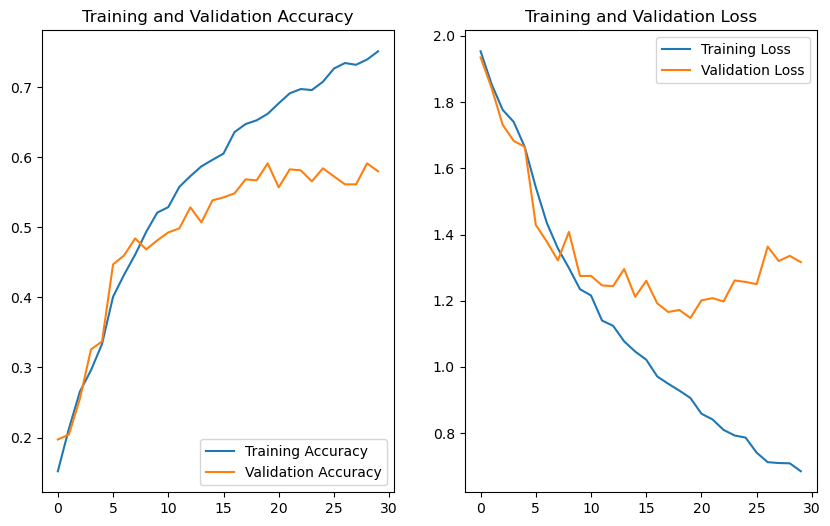

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
extend_epochs =20
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

Epoch 30/49
88/88 [==============================] - 59s 668ms/step - loss: 0.6703 - accuracy: 0.7507 - val_loss: 1.3035 - val_accuracy: 0.5700
Epoch 31/49
88/88 [==============================] - 58s 658ms/step - loss: 0.6774 - accuracy: 0.7543 - val_loss: 1.4410 - val_accuracy: 0.5571
Epoch 32/49
88/88 [==============================] - 59s 666ms/step - loss: 0.6469 - accuracy: 0.7668 - val_loss: 1.2541 - val_accuracy: 0.6129
Epoch 33/49
88/88 [==============================] - 58s 660ms/step - loss: 0.6085 - accuracy: 0.7779 - val_loss: 1.4323 - val_accuracy: 0.5643
Epoch 34/49
88/88 [==============================] - 59s 665ms/step - loss: 0.6332 - accuracy: 0.7664 - val_loss: 1.3295 - val_accuracy: 0.5786
Epoch 35/49
88/88 [==============================] - 59s 672ms/step - loss: 0.5845 - accuracy: 0.7850 - val_loss: 1.3281 - val_accuracy: 0.5900
Epoch 36/49
88/88 [==============================] - 59s 665ms/step - loss: 0.5865 - accuracy: 0.7800 - val_loss: 1.3460 - val_accuracy:

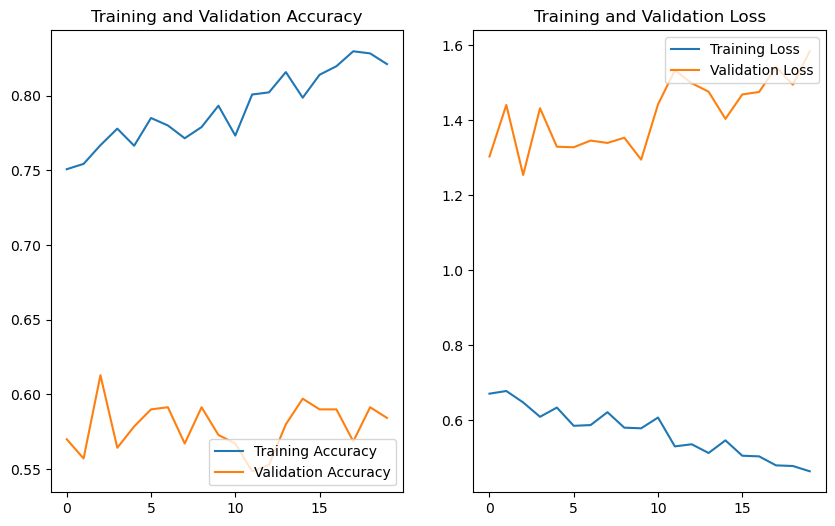

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
extend_epochs =20
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

Epoch 49/68
88/88 [==============================] - 41s 467ms/step - loss: 0.5038 - accuracy: 0.8068 - val_loss: 1.4572 - val_accuracy: 0.5914
Epoch 50/68
88/88 [==============================] - 41s 464ms/step - loss: 0.4640 - accuracy: 0.8311 - val_loss: 1.4659 - val_accuracy: 0.5929
Epoch 51/68
88/88 [==============================] - 41s 466ms/step - loss: 0.4525 - accuracy: 0.8336 - val_loss: 1.6518 - val_accuracy: 0.5729
Epoch 52/68
88/88 [==============================] - 41s 463ms/step - loss: 0.4410 - accuracy: 0.8339 - val_loss: 1.4814 - val_accuracy: 0.6029
Epoch 53/68
88/88 [==============================] - 41s 465ms/step - loss: 0.4533 - accuracy: 0.8293 - val_loss: 1.6624 - val_accuracy: 0.5886
Epoch 54/68
88/88 [==============================] - 41s 467ms/step - loss: 0.4520 - accuracy: 0.8296 - val_loss: 1.6698 - val_accuracy: 0.5586
Epoch 55/68
88/88 [==============================] - 41s 467ms/step - loss: 0.4372 - accuracy: 0.8400 - val_loss: 1.6389 - val_accuracy:

### Reducing input image size 

In [12]:
# reducing image size
batch_size =16
img_height=32
img_width=32

In [7]:
train_ds,val_ds = generate_data(16,32,32,'data/skinlesion_500_split_8020/train','data/skinlesion_500_split_8020/val')

Found 2800 files belonging to 7 classes.
Metal device set to: Apple M2
Found 700 files belonging to 7 classes.


2022-12-12 19:43:21.299004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 19:43:21.299666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.3),
    
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                  

In [15]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10,min_delta=0.0001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=50
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[es])

Epoch 1/50


2022-12-12 19:48:20.787567: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 19:48:20.789208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


172/175 [============================>.] - ETA: 0s - loss: 1.9287 - accuracy: 0.1806

2022-12-12 19:48:25.553478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 6s 29ms/step - loss: 1.9275 - accuracy: 0.1818 - val_loss: 1.8981 - val_accuracy: 0.2043
Epoch 2/50
175/175 [==============================] - 5s 28ms/step - loss: 1.7868 - accuracy: 0.2518 - val_loss: 1.7326 - val_accuracy: 0.2857
Epoch 3/50
175/175 [==============================] - 5s 29ms/step - loss: 1.7093 - accuracy: 0.2854 - val_loss: 1.7320 - val_accuracy: 0.3143
Epoch 4/50
175/175 [==============================] - 5s 29ms/step - loss: 1.5376 - accuracy: 0.3614 - val_loss: 1.4402 - val_accuracy: 0.4171
Epoch 5/50
175/175 [==============================] - 5s 29ms/step - loss: 1.4161 - accuracy: 0.4150 - val_loss: 1.3319 - val_accuracy: 0.4457
Epoch 6/50
175/175 [==============================] - 5s 29ms/step - loss: 1.3491 - accuracy: 0.4325 - val_loss: 1.3359 - val_accuracy: 0.4700
Epoch 7/50
175/175 [==============================] - 5s 29ms/step - loss: 1.2760 - accuracy: 0.4775 - val_loss: 1.2029 - val_accuracy: 0.5271
Epoch 8/50

### Note: 
Training time reduced drastically to 250 s for 50 epochs 

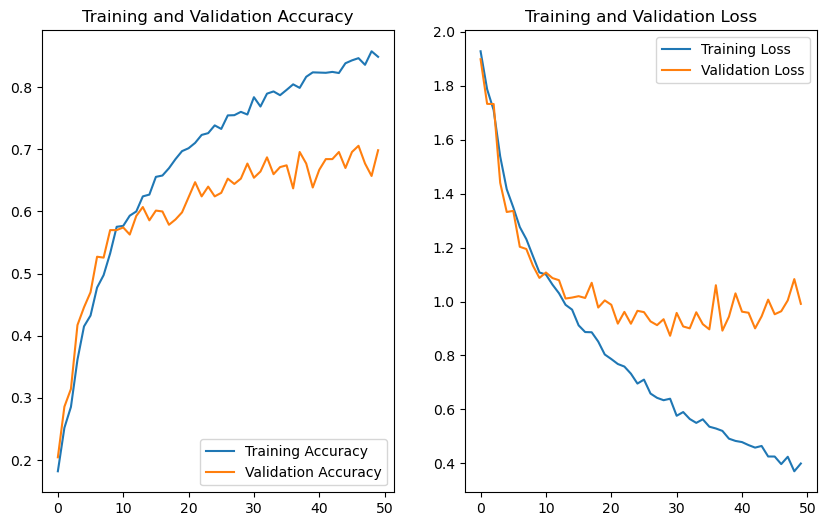

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
#some more training
extend_epochs =50
total_epochs = history.epoch[-1] +extend_epochs

history=model.fit(train_ds, validation_data=val_ds, 
                  initial_epoch=history.epoch[-1],
                  epochs=total_epochs)

Epoch 69/118
175/175 [==============================] - 5s 28ms/step - loss: 0.3063 - accuracy: 0.8889 - val_loss: 1.1614 - val_accuracy: 0.7214
Epoch 70/118
175/175 [==============================] - 5s 29ms/step - loss: 0.2536 - accuracy: 0.9043 - val_loss: 1.1604 - val_accuracy: 0.7214
Epoch 71/118
175/175 [==============================] - 5s 29ms/step - loss: 0.2640 - accuracy: 0.8950 - val_loss: 1.0996 - val_accuracy: 0.7200
Epoch 72/118
175/175 [==============================] - 5s 29ms/step - loss: 0.2784 - accuracy: 0.9029 - val_loss: 1.0786 - val_accuracy: 0.7143
Epoch 73/118
175/175 [==============================] - 5s 29ms/step - loss: 0.2480 - accuracy: 0.9079 - val_loss: 1.2040 - val_accuracy: 0.7329
Epoch 74/118
175/175 [==============================] - 5s 30ms/step - loss: 0.2379 - accuracy: 0.9111 - val_loss: 1.2569 - val_accuracy: 0.7014
Epoch 75/118
175/175 [==============================] - 5s 29ms/step - loss: 0.2411 - accuracy: 0.9082 - val_loss: 1.3114 - val_ac

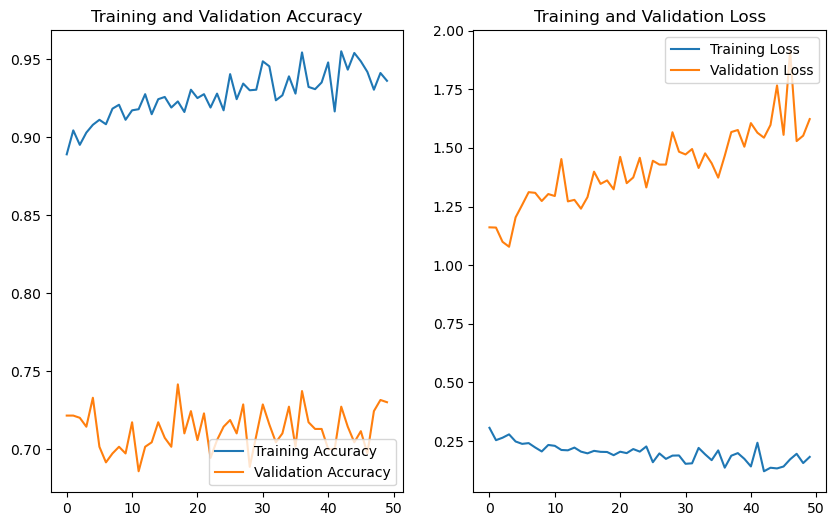

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
### Using model for inference on val data
y_true =  []
y_preds =[]
y_test_proba = np.array([],dtype=np.float32).reshape(0,7)

for img_batch,label_batch in val_ds:
    
    test_preds_proba = model.predict(img_batch)
    y_test_proba=np.concatenate((y_test_proba,test_preds_proba),axis=0)
    
    test_pred = np.argmax(test_preds_proba,axis=-1)
    
    for i in range(len(label_batch)):
        test_label = class_names[label_batch[i]]
        y_true.append(test_label)
        pred_class = class_names[test_pred[i]]
        y_preds.append(pred_class)
print(len(y_true))
print(len(y_preds))
print(y_test_proba.shape)

1/1 [==============================] - 0s 9ms/step


2022-12-12 20:08:42.224078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 18ms/step
700
700
(700, 7)


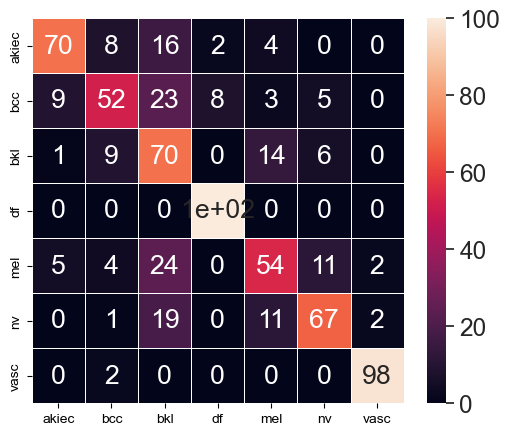

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_preds)
fig, ax = plt.subplots(figsize=(6,5))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
fig.show()

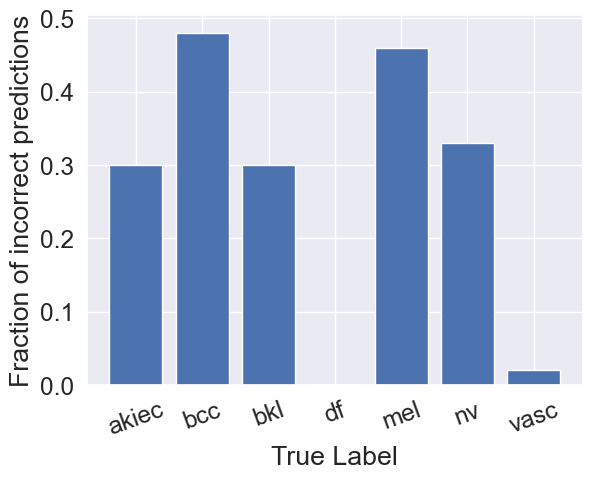

In [30]:
#PLot fractional incorrect misclassifications
# plt.figure(figsize=(6,5))
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')
plt.xticks([0,1,2,3,4,5,6], class_names,rotation=20)
plt.show()

1/1 [==============================] - 0s 9ms/step


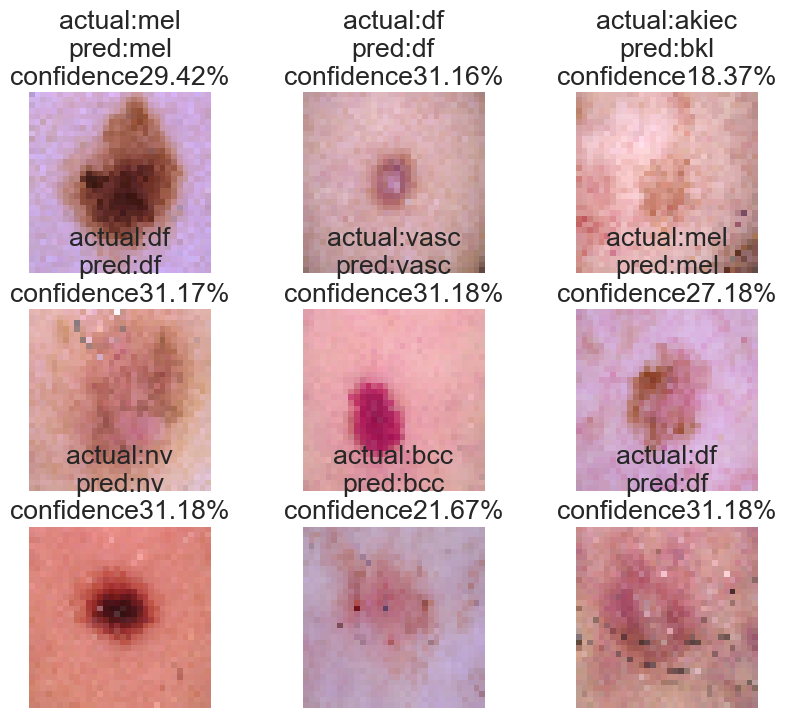

In [32]:
plt.figure(figsize=(10, 8))
for img_batch, label_batch in val_ds.take(1):
    predictions = model.predict(img_batch)
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        pred_class = class_names[np.argmax(predictions[i])]
        pred_score = tf.nn.softmax(predictions[i])
        percent = round(100*np.max(pred_score), 2)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title("actual:"+class_names[label_batch[i]]+"\npred:"+pred_class+"\nconfidence"+str(percent)+"%")
        plt.axis("off")
        plt.tight_layout

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_preds,labels=class_names))

              precision    recall  f1-score   support

       akiec       0.82      0.70      0.76       100
         bcc       0.68      0.52      0.59       100
         bkl       0.46      0.70      0.56       100
          df       0.91      1.00      0.95       100
         mel       0.63      0.54      0.58       100
          nv       0.75      0.67      0.71       100
        vasc       0.96      0.98      0.97       100

    accuracy                           0.73       700
   macro avg       0.75      0.73      0.73       700
weighted avg       0.75      0.73      0.73       700



In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize

In [35]:
classes = np.unique(y_true)

In [36]:
y_test_binarized = label_binarize(y_true,classes=np.unique(y_true)) 

In [37]:
y_test_binarized.shape

(700, 7)

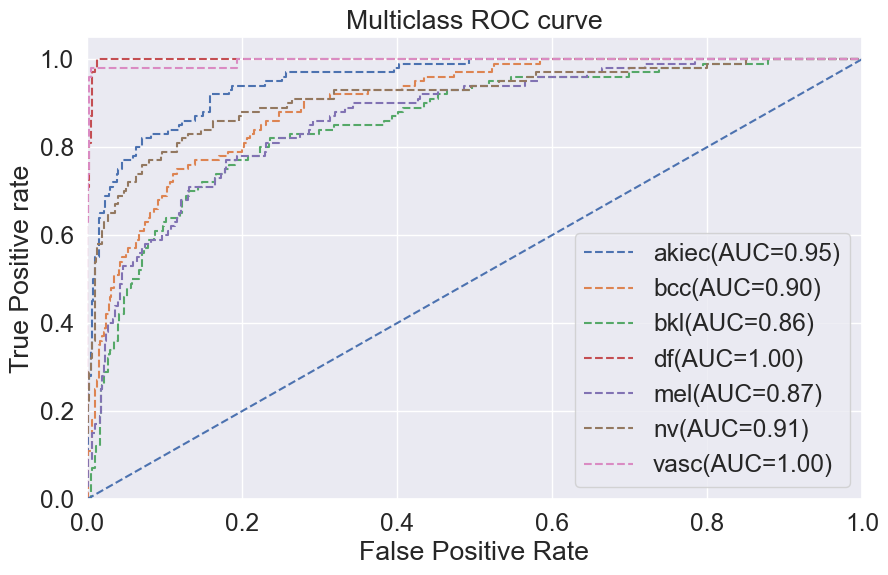

In [38]:
#roc curve for all classes
fpr ={}
tpr={}
thresh ={}
roc_auc=dict()

plt.figure(figsize=(10,6))

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_test_proba[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s(AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [39]:
roc_auc_score(y_test_binarized,y_test_proba,multi_class='ovr')

0.9258857142857142

In [40]:
model.save("models/baseline_500_32_73acc.h5")